In [1]:
#sources
# https://www.kaggle.com/mauricef/titanic
# https://www.kaggle.com/vbmokin/titanic-top-3-one-line-of-the-prediction-code
 #https://www.kaggle.com/vbmokin/titanic-0-83253-comparison-20-popular-models

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
train = pd.read_csv('../input/titanic/train.csv').set_index('PassengerId')
test = pd.read_csv('../input/titanic/test.csv').set_index('PassengerId')
df = pd.concat([train, test], axis=0, sort=False)

In [3]:
df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female'))
df['LastName'] = df.Name.str.split(',').str[0]

family = df.groupby(df.LastName).Survived
df['WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
df['WomanOrBoyCount'] = df.mask(df.IsWomanOrBoy, df.WomanOrBoyCount - 1, axis=0)
df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
df['FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.FamilySurvivedCount - df.Survived.fillna(0), axis=0)
df['WomanOrBoySurvived'] = df.FamilySurvivedCount / df.WomanOrBoyCount.replace(0, np.nan)

df.WomanOrBoyCount = df.WomanOrBoyCount.replace(np.nan, 0)
df['Alone'] = (df.WomanOrBoyCount == 0)

In [4]:
#"Title" improvement
df['Title'] = df['Title'].replace('Ms','Miss')
df['Title'] = df['Title'].replace('Mlle','Miss')
df['Title'] = df['Title'].replace('Mme','Mrs')

In [5]:
# Embarked 
#replace missing values with the most common place of embarkment (Southampton)
#df['Embarked'] = df['Embarked'].fillna('S')

# identify the context and find passengers who paid similar money for a ticket (Cherbourg)
df[df.Embarked.isnull()]
df.groupby('Embarked', as_index = False)['Fare'].mean()
df.Embarked.fillna("C", inplace = True)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone
PassengerId,,,,,,,,,,,,,,,,,,
62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,True,Icard,0.0,0,NaN,True
830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,True,Stone,0.0,0,NaN,True


,Embarked,Fare
0,C,62.336267
1,Q,12.409012
2,S,27.418824


In [6]:
# Cabin, Deck
df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df.loc[(df['Deck'] == 'T'), 'Deck'] = 'A'

In [7]:
# Fare
# fill a mean fare in the class
med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df['Fare'] = df['Fare'].fillna(med_fare)

In [8]:
#Age
df['Age'] = df.groupby(['Sex', 'Pclass', 'Title'])['Age'].apply(lambda x: x.fillna(x.median()))

In [9]:
# Family_Size
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

In [10]:
cols_to_drop = ['Name','Ticket','Cabin']
df = df.drop(cols_to_drop, axis=1)

df.WomanOrBoySurvived = df.WomanOrBoySurvived.fillna(0)
df.WomanOrBoyCount = df.WomanOrBoyCount.fillna(0)
df.FamilySurvivedCount = df.FamilySurvivedCount.fillna(0)
df.Alone = df.Alone.fillna(0)

In [11]:
#check for the total of null values
df.isnull().sum()

Survived               418
Pclass                   0
Sex                      0
Age                      0
SibSp                    0
Parch                    0
Fare                     0
Embarked                 0
Title                    0
IsWomanOrBoy             0
LastName                 0
WomanOrBoyCount          0
FamilySurvivedCount      0
WomanOrBoySurvived       0
Alone                    0
Deck                     0
Family_Size              0
dtype: int64

In [12]:
target = df.Survived.loc[train.index]
train, test = df.loc[train.index], df.loc[test.index]

In [13]:
# Converting categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = train.columns.values.tolist()
for col in features:
    if train[col].dtype in numerics: continue
    categorical_columns.append(col)
categorical_columns

for col in categorical_columns:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

['Sex', 'Embarked', 'Title', 'IsWomanOrBoy', 'LastName', 'Alone', 'Deck']

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

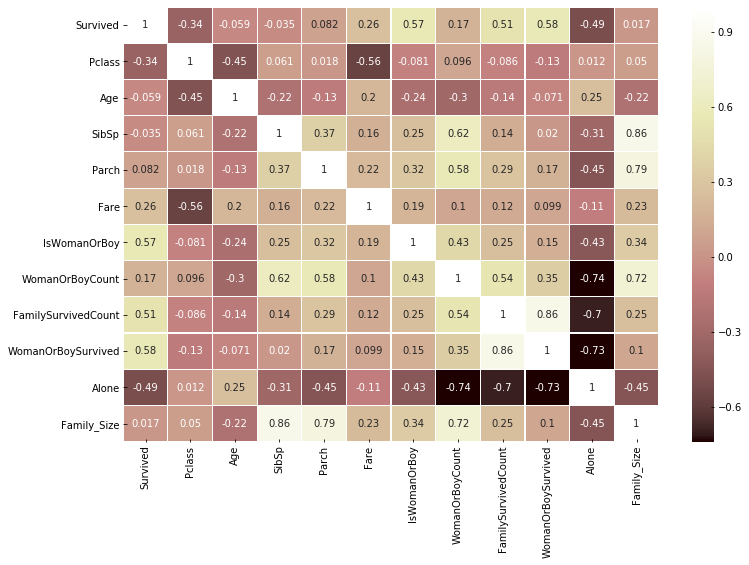

In [14]:
sns.heatmap(df.corr(),annot = True,cmap = 'pink',linewidths = 0.2);
fig = plt.gcf();
fig.set_size_inches(12,8);
plt.show();

In [15]:
train.Survived = train.Survived.astype(int)
test = test.drop(['Survived'], axis=1)

In [16]:
train.to_csv('trainC.csv', index = False)
test.to_csv('testC.csv', index = False)
train.head()
test.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Deck,Family_Size
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,2,10,0,100,0.0,0.0,0.0,1,7,2
2,1,1,0,38.0,1,0,71.2833,0,11,1,182,0.0,0.0,0.0,1,2,2
3,1,3,0,26.0,0,0,7.9250,2,9,1,329,0.0,0.0,0.0,1,7,1
4,1,1,0,35.0,1,0,53.1000,2,11,1,267,0.0,0.0,0.0,1,2,2
5,0,3,1,35.0,0,0,8.0500,2,10,0,15,0.0,0.0,0.0,1,7,1


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Deck,Family_Size
PassengerId,,,,,,,,,,,,,,,,
892,3,1,34.5,0,0,7.8292,1,10,0,401,0.0,0.0,0.0,1,7,1
893,3,0,47.0,1,0,7.0000,2,11,1,846,0.0,0.0,0.0,1,7,2
894,2,1,62.0,0,0,9.6875,1,10,0,552,0.0,0.0,0.0,1,7,1
895,3,1,27.0,0,0,8.6625,2,10,0,854,0.0,0.0,0.0,1,7,1
896,3,0,22.0,1,1,12.2875,2,11,1,342,1.0,1.0,1.0,0,7,3
